In [11]:
import numpy as np
# from sklearn.neighbors import NearestNeighbors
import glob
import rosbag
import rospy
from urdf_parser_py.urdf import URDF
from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
from pykdl_utils.kdl_kinematics import KDLKinematics

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 

In [12]:
data_path = './Robot_ViconNovember/'

In [13]:
# Extract Vicon and camera dynamic data
## Load Vicon data
vicobags_dyna = glob.glob(data_path+'VD/*.bag')
for i,bag in enumerate(vicobags_dyna): # loop over vicon bags
    vdbag = rosbag.Bag(bag)
    vicon_dynaXpos = []
    vicon_dynaYpos = []
    vicon_dynaZpos = []
    viconbag_time_dyna = []
    for topicc, msgg, tt in vdbag.read_messages(topics=['/vicon/PEE/PEE']): # extract data
        vicon_dynaXpos.append(msgg.transform.translation.x)
        vicon_dynaYpos.append(msgg.transform.translation.y)
        vicon_dynaZpos.append(msgg.transform.translation.z) 
        vicon_time_dy = tt.secs
        viconbag_time_dyna.append(vicon_time_dy)
    vdbag.close()

    vicon_dynaXPosArr = np.array(vicon_dynaXpos)
    vicon_dynaYPosArr = np.array(vicon_dynaYpos)
    vicon_dynaZPosArr = np.array(vicon_dynaZpos)
    vicon_dynaPosArr = np.column_stack((vicon_dynaXPosArr,vicon_dynaYPosArr,vicon_dynaZPosArr)) 
    np.save(data_path+'vicon_dynaPosArr%d.npy'%i, vicon_dynaPosArr) # save to numpy
    np.save(data_path+'viconbag_time_dyna%d.npy'%i, viconbag_time_dyna)
    
# Load Robot data    
robobags_dyna = glob.glob(data_path+'RD/*.bag')
for i,bag in enumerate(robobags_dyna): # loop over robot bags
    rdbag = rosbag.Bag(bag)
    robot_dynaXpos = []
    robot_dynaYpos = []
    robot_dynaZpos = []
    robotbag_Tagtime_dyna = [] # \this was spelt wrong
    for topi, msgs, tym in rdbag.read_messages(topics=['/tag_detections']): # extract data
        try:
            robot_dynaXpos.append(msgs.detections[0].pose.pose.pose.position.x)
            robot_dynaYpos.append(msgs.detections[0].pose.pose.pose.position.y)
            robot_dynaZpos.append(msgs.detections[0].pose.pose.pose.position.z)   
            robotbag_Tagtime_dyna.append(tym.secs)
        except:
            continue

    robot_dynaXposArr = np.array(robot_dynaXpos)
    robot_dynaYposArr = np.array(robot_dynaYpos)
    robot_dynaZposArr = np.array(robot_dynaZpos)
    robot_dynaposArr = np.column_stack((robot_dynaXposArr,robot_dynaYposArr,robot_dynaZposArr))
    np.save(data_path+'robot_dynaPosArr%d.npy'%i, robot_dynaposArr)
    np.save(data_path+'robotbag_Tagtime_dyna%d.npy'%i, robotbag_Tagtime_dyna)
    
    
    robotbag_Jointstime_dyna = []
    ja_list = []
    for topic2, msg2, t2 in rdbag.read_messages(topics=['/Packbot510/joints']):
        ja_list.append(msg2.position[:3])
        robotbag_Jointstime_dyna.append(t2.secs)
    ja_array_dyna = np.array(ja_list)
    rdbag.close()
    np.save(data_path+'ja_array_dyna%d.npy'%i, ja_array_dyna)
    np.save(data_path+'robotbag_Jointstime_dyna%d.npy'%i, robotbag_Jointstime_dyna)

In [14]:
# Sanity check loading data we just saved
vicon_dylist = []
camera_dylist = []
kinematics_list_dyna = []

tk = []
tc = []
tv = []

for i in range(len(vicobags_dyna)):
    vicon_dy = np.load(data_path+'vicon_dynaPosArr%d.npy'%i)
    vicon_dylist.append(vicon_dy)
    v_time = np.load(data_path+'viconbag_time_dyna%d.npy'%i) # Name was wrong. missing dyna
    tv.append(v_time)
   
    robot_dy = np.load(data_path+'robot_dynaPosArr%d.npy'%i)
    camera_dylist.append(robot_dy)
    c_time = np.load(data_path+'robotbag_Tagtime_dyna%d.npy'%i) # Name was wrong. missing dyna
    tc.append(c_time)
    
    RobotKin_dy = np.load(data_path+'ja_array_dyna%d.npy'%i)
    kinematics_list_dyna.append(RobotKin_dy)
    k_time = np.load(data_path+'robotbag_Jointstime_dyna%d.npy'%i)
    tk.append(k_time)
    

In [17]:
robot = URDF.from_xml_file('robot.urdf')
links = [rl.name for rl in robot.links]
kdl_kin_dy = KDLKinematics(robot,'base_link','elbow2_link')
#print(kdl_kin.get_joint_names())

BaseTo_ee_xyz_dyna = []
for dy in kinematics_list_dyna:
    ee_list_dy = []
    for joints in dy:
        posez_dy = kdl_kin_dy.forward(joints)
        ee_list_dy.append(posez_dy[0:3,3])
    BaseTo_ee_xyz_dyna.append(np.squeeze(np.array(ee_list_dy)))
# np.save(data_path+'BaseTo_ee_xyz_dyna%d.npy'%i, BaseTo_ee_xyz_dyna)

In [19]:
BaseTo_ee_xyz_dyna

[]

In [18]:
#manually aligning the robot data to vicon frame
theta = np.radians(91)
translation = [0,0.056,0.038]
Rot_mat = np.array([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta), np.cos(theta), 0],[0,0,1]])
transformedRobot = (np.dot(Rot_mat,((BaseTo_ee_xyz_dyna[8]).T)).T) - translation

IndexError: list index out of range

In [8]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''
    
    #assert A.shape == B.shape  ####commented  all the assert statements 
                                ####coz they were gving me shape erros whereas the datasets shapes were the same,

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''
    
    #assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''
    
    #assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T #,i

In [9]:
icpTransformation = icp(transformedRobot,vicon_dylist[8], init_pose=None, max_iterations=100000, tolerance=1e-9)
print(transformedRobot.shape)  # to get the numer of rows 

NameError: name 'transformedRobot' is not defined

In [10]:
#extend robot array to be n*4 by concatination a column of ones to match the 4*4 icpTransformation
homo_transformedRobot = np.c_[ transformedRobot, np.ones(1003) ] #the number of ones to add always changes per dataset.

NameError: name 'transformedRobot' is not defined

In [10]:
robotICP_inVicon = (np.dot(icpTransformation,homo_transformedRobot.T)).T
robotICP_inVicon.shape

(1003, 4)

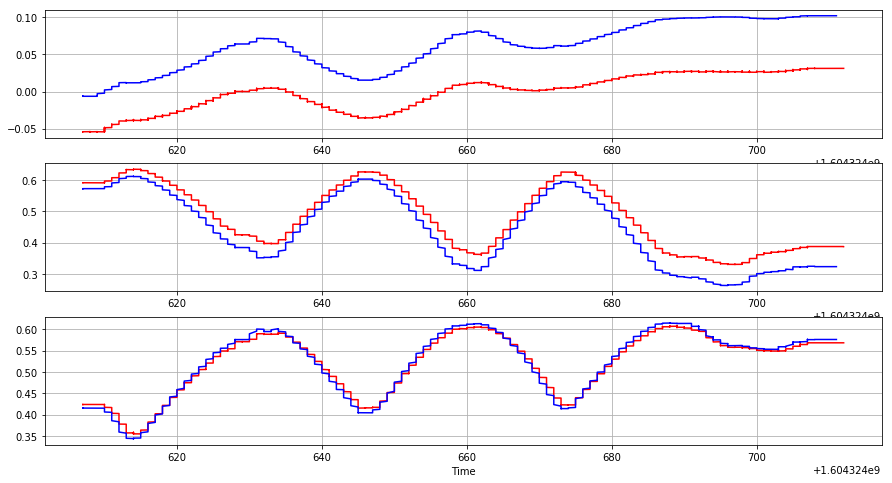

In [11]:

fig, axs = plt.subplots(3,figsize =(15,8))
plt.xlabel('Time')
axs[0].grid()
axs[1].grid()
axs[2].grid()

#Plot vicon data
axs[0].plot((tv[8]),vicon_dylist[8][:,0],c='r')
axs[1].plot((tv[8]),vicon_dylist[8][:,1],c='r')
axs[2].plot((tv[8]),vicon_dylist[8][:,2],c='r')


# axs[0].plot((tc[3]),camera_dylist[3][:,0],c='g')
# axs[1].plot((tc[3]),camera_dylist[3][:,1],c='g')
# axs[2].plot((tc[3]),camera_dylist[3][:,2],c='g')

#Plot kinematics data
axs[0].plot((tk[8]),transformedRobot[:,0],c='b') 
axs[1].plot((tk[8]),transformedRobot[:,1],c='b')
axs[2].plot((tk[8]),transformedRobot[:,2],c='b')

plt.show()

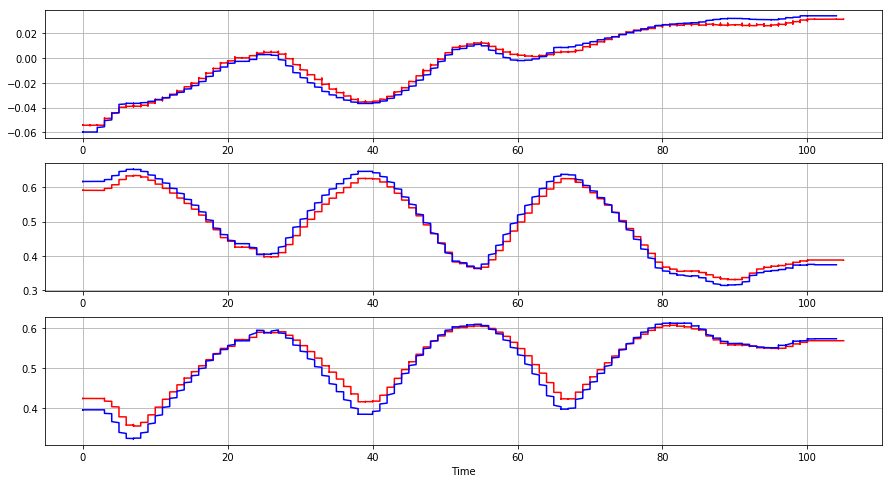

In [12]:
fig, axs = plt.subplots(3,figsize =(15,8))
plt.xlabel('Time')
axs[0].grid()
axs[1].grid()
axs[2].grid()

#Plot vicon data
axs[0].plot((tv[8]-tv[8][0]),vicon_dylist[8][:,0],c='r')
axs[1].plot((tv[8]-tv[8][0]),vicon_dylist[8][:,1],c='r')
axs[2].plot((tv[8]-tv[8][0]),vicon_dylist[8][:,2],c='r')

# # #Plot camera data
# axs[0].plot((tc[3]),camera_dylist[3][:,0],c='g')
# axs[1].plot((tc[3]),camera_dylist[3][:,1],c='g')
# axs[2].plot((tc[3]),camera_dylist[3][:,2],c='g')

#Plot kinematics data
axs[0].plot((tk[8]-tk[8][0]),robotICP_inVicon[:,0],c='b') 
axs[1].plot((tk[8]-tk[8][0]),robotICP_inVicon[:,1],c='b')
axs[2].plot((tk[8]-tk[8][0]),robotICP_inVicon[:,2],c='b')

plt.show()